In [1]:
import numpy as np

In [2]:
def log_prob(x,mu,cov):
    diff=x-mu
    return -0.5*np.dot(diff,np.linalg.solve(cov,diff))

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pprint
from scipy.optimize import differential_evolution
from scipy.optimize import shgo
from scipy.optimize import dual_annealing
from multiprocessing import Pool
import multiprocessing as multi
from scipy.optimize import LinearConstraint
from scipy.optimize import Bounds
from time import sleep
import pickle 
import datetime 

N_ini=np.array([0.54,0.26,0.20])
per_ini=0.0001
S_ini=(1-per_ini)*N_ini
I_ini=per_ini*N_ini
R_ini=np.array([0.,0.,0.])
D_ini=np.array([0.,0.,0.])
state_ini=np.vstack([S_ini,I_ini,R_ini,D_ini])
state_ini=state_ini.flatten()

kappa=np.array([0.,0.,0.])#回復者が自由に働けるように特定される割合
beta=0.134#感染力
gamma=1/18#感染期間の逆数
chi=35*365

t_max=360
dt=0.1
t=np.arange(0,t_max,dt)
interval=30

theta=0.75
alpha=2
eta=0.9
rho_sc=1
rho=np.array([[1,rho_sc,rho_sc],[rho_sc,1,rho_sc],[rho_sc,rho_sc,1]])

e=0.05#ワクチンによる重症化の減少割合

w=np.array([1.,1.,0.26])#各世代の稼ぎ
Delta=np.array([32.5*365,10.0*365,2.5*365])
zeta=0.3
phi=np.array([0.1,0.1,0.1])#各世代のICUが必要なものが特定されて隔離される割合

fatality_rate=np.array([0.001,0.01,0.06])
sigma=0.0076
iota=sigma*fatality_rate#各世代の感染者のうち、ICUが必要となる割合
iotav=0.05*iota
delta_d_underbar=gamma*fatality_rate/iota#基準となるICUのニーズ

def H(I):
    return sigma*(np.dot(fatality_rate,I))

def lam(N):
    return 1/(sigma*np.dot(fatality_rate,N))

def delta_d(N,I):
    return delta_d_underbar*(1+lam(N)*H(I))


#このパラメーターの場合、ロックダウンの強度は0.428で感染者数が一定になる

def M(S,I,R,L):
    m=np.array([0.,0.,0.])
    for j in range(3):
        m[j]=(np.dot(rho[j],(S+eta*I+(1-kappa)*R)*(1-theta*L)+kappa*R))**(alpha-2)
    return m

def mgsir_eq(state,t,*L):
    L=np.array(L).reshape(t_max//interval,-1)
    state=state.reshape(4,3)
    
    S=state[0]
    I=state[1]
    R=state[2]
    D=state[3]
    
    dI=beta*(1-theta*L[min(int(t/interval),int((t_max-1)/interval))])*S*np.dot(rho,eta*(1-theta*L[min(int(t/interval),int((t_max-1)/interval))])*I)-gamma*I
    dS=-dI-gamma*I
    dD=delta_d(S+I+R+D,I)*iota*I
    dR=(gamma-delta_d(S+I+R+D,I))*iota*I+gamma*(I-iota*I)
    
    return np.vstack([dS,dI,dR,dD]).flatten()

def death(result):
    return result[-1,9]+result[-1,10]+result[-1,11]

def psi(result,L):
    Psi=np.array([0.0,0.0,0.0])
    L=np.array(L).reshape(t_max//interval,-1)
    for t in range(t_max):
        #print(t)
        S=result[t,0:3]
        I=result[t,3:6]
        R=result[t,6:9]
        D=result[t,9:12]
        Psi=Psi+(1-zeta)*w*S*L[min(int(t/interval),int((t_max-1)/interval))]+(1-zeta)*w*I*(1-eta*(1-L[min(int(t/interval),int((t_max-1)/interval))]))
        +(1-zeta)*w*(1-kappa)*R*L[min(int(t/interval),int((t_max-1)/interval))]+w*Delta*iota*delta_d(S+I+R+D,I)*I
    return np.sum(Psi)

count=0
mincost=100000
minL=()
def economical_cost(L):
    L=tuple(L)
    for i in range(len(L)):
        if L[i]>1 or L[i]<0:
            return -np.inf
    result=odeint(mgsir_eq,state_ini,t,args=L)[::int(1/dt),:]
    Death=death(result)
    Psi=psi(result,L)
    global count
    global mincost
    global minL
    count=count+1
    if Psi+chi*Death<mincost:
        mincost=Psi+chi*Death
        minL=L
    if count%5000==0:
        print(Psi+chi*Death,mincost,minL)
    return -(Psi+chi*Death)


In [6]:
import emcee

nwalkers=36
ndim=12
p0 = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, economical_cost)
#state = sampler.run_mcmc(p0, 100)
#sampler.reset()

In [7]:
sampler.run_mcmc(p0, 10000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


In [8]:

now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
path = f"./{now}.db"
print(path)
with open(path, "wb") as buff:
    pickle.dump({"sampler":sampler},buff)

./20210209_151037.db


In [9]:
path = "./20210209_151037.db"
with open(path, "rb") as buff:
    sampler = pickle.load(buff)["sampler"]

In [10]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.220


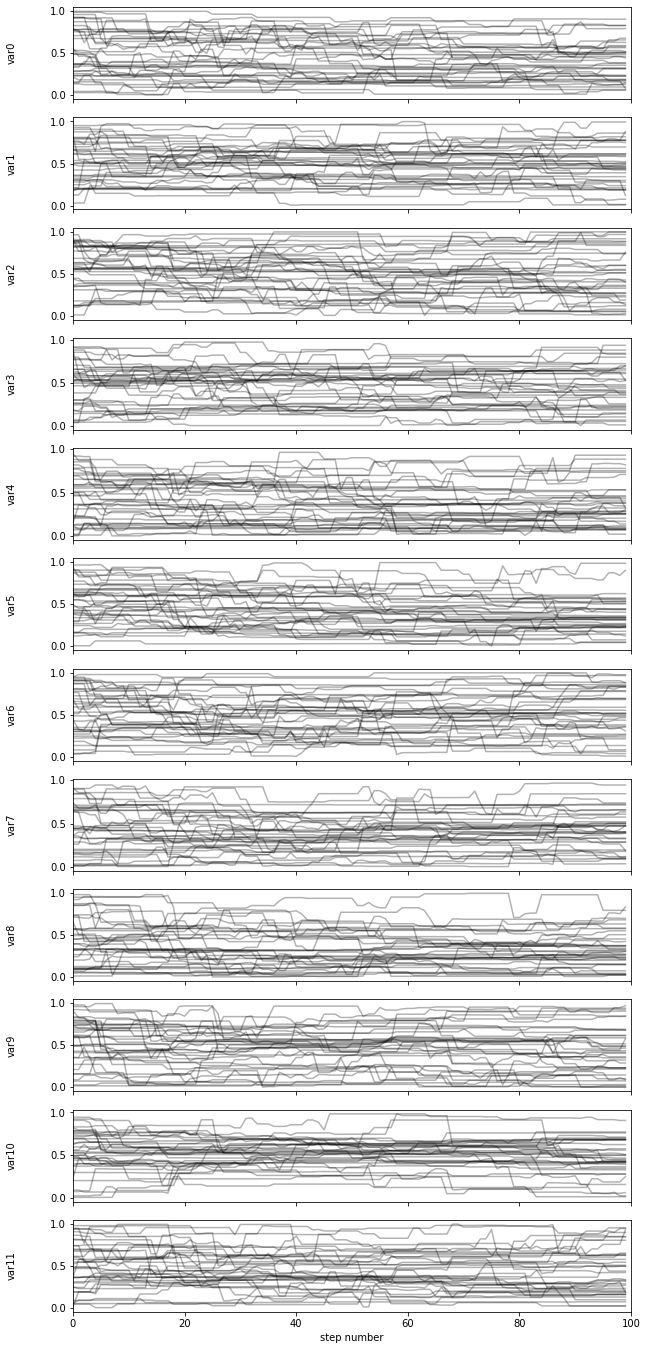

In [11]:
fig, axes = plt.subplots(12, figsize=(10, ndim*2), sharex=True)
samples = sampler.get_chain()
labels = [f"var{i}" for i in range(ndim)]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [12]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 12 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [ 9.77574978 10.76730789 10.35602166 10.22629976 10.09307931 10.18223823
 10.15941496  9.23040968 10.74780408  9.95738029 10.22377436 10.67864283]

In [13]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(0, 12)


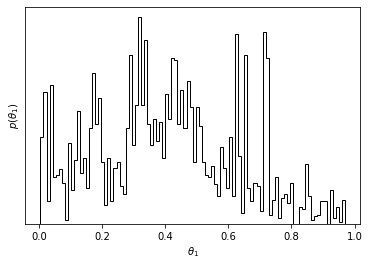

In [14]:
import matplotlib.pyplot as plt

#arviz
#az.summary
#hdi_prob

samples = sampler.get_chain(flat=True)
plt.hist(samples[:,7] , 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

In [16]:
import arviz as az
az.summary(sampler)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
var_0,0.442,0.254,0.060,0.908,0.039,0.027,43.0,43.0,44.0,64.0,2.97
var_1,0.501,0.222,0.180,0.966,0.033,0.023,46.0,46.0,47.0,67.0,2.51
var_2,0.500,0.263,0.008,0.894,0.039,0.028,45.0,45.0,47.0,86.0,2.50
var_3,0.456,0.231,0.002,0.809,0.035,0.025,44.0,44.0,45.0,64.0,2.83
var_4,0.372,0.242,0.010,0.779,0.036,0.026,45.0,45.0,48.0,104.0,2.30
var_5,0.423,0.228,0.025,0.814,0.034,0.024,45.0,45.0,45.0,61.0,2.72
var_6,0.501,0.251,0.124,0.987,0.037,0.026,46.0,46.0,47.0,60.0,2.46
var_7,0.406,0.224,0.004,0.756,0.033,0.024,45.0,45.0,47.0,84.0,2.53
var_8,0.344,0.231,0.002,0.757,0.035,0.025,45.0,45.0,47.0,70.0,2.51
var_9,0.459,0.259,0.000,0.863,0.038,0.027,45.0,45.0,47.0,104.0,2.40
